In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [9]:
dataPath = os.path.join('..','Data', 'Silhouettes.mat')
mat = scipy.io.loadmat(dataPath)
Fem = mat['Fem'].ravel() - 1 # Get rid of outer dim, -1 due to stupid matlab indexing
Male = mat['Male'].ravel() - 1
num_female = Fem.size
num_male = Male.size
Xa = mat['Xa']
gamma = np.linspace(0.01, 0.99, 12) #  try in the range [0.01,0.99]

rng = np.random.default_rng(seed=42)

### 3 Implement and calculate a Regularized Discriminant Analysis (RDA) for the Silhouette data in Silhouettes.mat

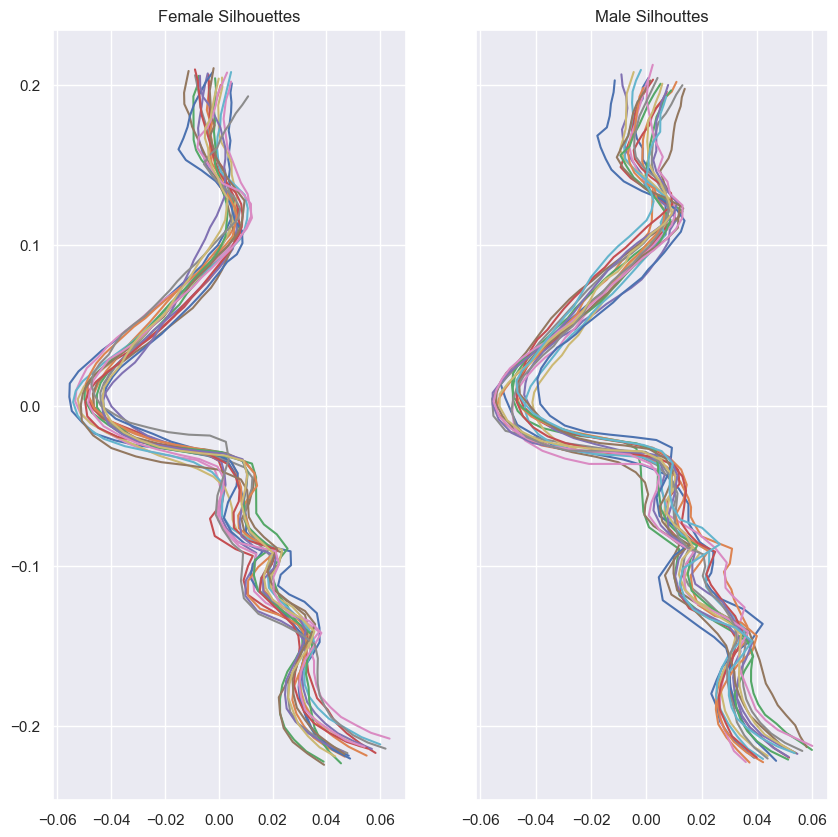

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))
ax1.plot(Xa[Fem,:65].T, Xa[Fem, 65:].T)
ax1.set_title("Female Silhouettes")
ax2.plot(Xa[Male, :65].T, Xa[Male, 65:].T)
ax2.set_title("Male Silhouttes")
plt.show()

In [14]:
Xa[Fem].shape

(19, 130)

In [16]:
np.cov(Xa[Fem]).shape

(19, 19)

> (a) What happens when we vary $\gamma$ in RDA?

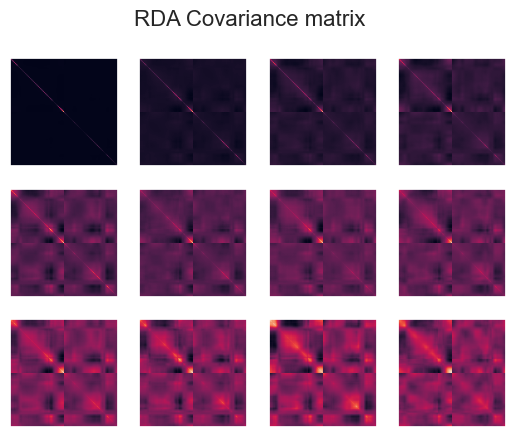

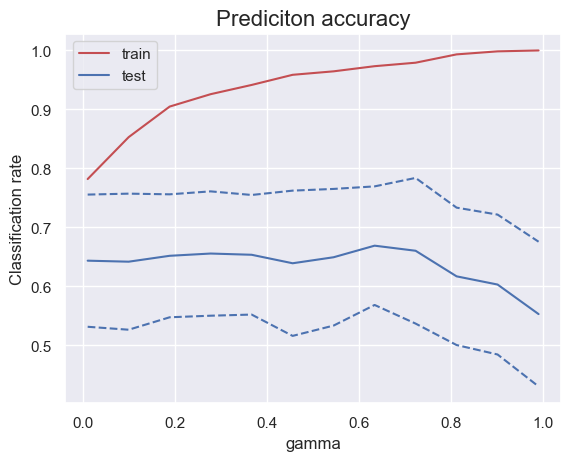

In [47]:
iterations = 100
cl_tr = np.zeros(iterations)
cl_tst = np.zeros(iterations)
train = np.zeros(len(gamma))
test = np.zeros(len(gamma))
s_test = np.zeros(len(gamma))

gamma = np.linspace(0.01, 0.99, 12) #  try in the range [0.01,0.99]


fig, axis = plt.subplots(3,4)

plt_col = 0
plt_row = -1
fig.suptitle('RDA Covariance matrix', fontsize=16)
for j in range(len(gamma)):
    for i in range(iterations):
        #Retrieve bootstrap sample. Hint: Use numpy's random.choice
        femP = rng.choice(Fem, size=num_female, replace=True)
        maleP = rng.choice(Male, size=num_male, replace=True)
        
        #Retrieve Out-of-Bootstrap samples. Hint. Use "List Comprehension". For x in Fem add to list if x not in femP ect.
        femOOB = [x for x in Fem.tolist() if x not in femP]
        maleOOB = [x for x in Male.tolist() if x not in maleP]
        
        #Concat gendered data sets
        train_sample = np.concatenate([femP, maleP])[:, None]
        test_sample = femOOB + maleOOB
        
        # get means of the two classes
        mu_fem = np.mean(Xa[femP], axis=0)
        mu_male = np.mean(Xa[maleP], axis=0)
        
        # Calculate the pooled within class covariance matrix
        Sp = ((num_female - 1) * np.cov(Xa[femP], rowvar=0) + (num_male - 1) * np.cov(Xa[maleP],rowvar=0)) / (num_female + num_male - 2)

        # Calculate the regularized discriminant analysis estimate of the covariance matrix
        Srda = gamma[j] * Sp + (1-gamma[j]) * np.diag(np.diag(Sp))
        # predict train and test
        
        const_fem = 0.5 * mu_fem @ np.linalg.solve(Srda, mu_fem)
        const_male = 0.5 * mu_male @ np.linalg.solve(Srda, mu_male)
        score_fem = mu_fem @ np.linalg.solve(Srda, Xa.T) - const_fem
        score_male = mu_male @ np.linalg.solve(Srda, Xa.T) - const_male
        
        #Compute classification accuracy
        class_true = np.ones((Xa.shape[0]))
        class_true[Male] = 2
        class_pred = (score_male>score_fem)+1

        cl_tr[i] = np.mean(class_true[train_sample]==class_pred[train_sample]) #classification rate/prediction accuracy train
        cl_tst[i] = np.mean(class_true[test_sample]==class_pred[test_sample]) #classification rate/prediction accuracy test

    train[j] = np.mean(cl_tr)
    test[j] = np.mean(cl_tst)
    s_test[j] = np.std(cl_tst)

    plt_col = j % 4
    if plt_col == 0:
        plt_row +=1
    axis[plt_row, plt_col].grid(None)
    axis[plt_row, plt_col].set_xticks([])
    axis[plt_row, plt_col].set_yticks([])
    axis[plt_row, plt_col].imshow(Srda)
    plt.grid(None)
    
    
plt.show()   

plt.figure(4)
plt.plot(gamma,train,'r-')
plt.xlabel('gamma')
plt.ylabel('Classification rate')
plt.plot(gamma,test,'b-')
plt.plot(gamma,test-s_test,'b--')
plt.plot(gamma,test+s_test,'b--')
plt.legend(('train','test'))
plt.title('Prediciton accuracy', fontsize=16)
plt.show()